In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/OpenMP_6.csv")


In [3]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["problemSize"] = dataFrame["problemSize"].astype(int)
dataFrame["numThreads"] = dataFrame["numThreads"].astype(int)
dataFrame["chunk"] = dataFrame["chunk"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)
dataFrame["heavyProbability"] = dataFrame["heavyProbability"].astype(float)

print("Loaded rows:", len(dataFrame))
print("Problem sizes:", sorted(dataFrame["problemSize"].unique()))
print("Chunk sizes:", sorted(dataFrame["chunk"].unique()))
print("Schedules:", sorted(dataFrame["schedule"].unique()))
print("Thread counts:", sorted(dataFrame["numThreads"].unique()))
dataFrame.head(8)


Loaded rows: 2160
Problem sizes: [10000, 50000, 100000]
Chunk sizes: [1, 10, 100]
Schedules: ['dynamic', 'guided', 'static']
Thread counts: [1, 2, 4, 6, 8, 16, 32, 64]


,testType,problemSize,numThreads,schedule,chunk,timeSeconds,resultSum,heavyProbability,lightWork,heavyWork,runIndex,ompEnv
0,OpenMP_6,10000,1,static,1,0.040969,882973.0,0.05,10,1000,1,OMP_NUM_THREADS=1
1,OpenMP_6,10000,1,static,1,0.042892,941359.0,0.05,10,1000,2,OMP_NUM_THREADS=1
2,OpenMP_6,10000,1,static,1,0.041991,925136.0,0.05,10,1000,3,OMP_NUM_THREADS=1
3,OpenMP_6,10000,1,static,1,0.046712,931566.0,0.05,10,1000,4,OMP_NUM_THREADS=1
4,OpenMP_6,10000,1,static,1,0.044256,964087.0,0.05,10,1000,5,OMP_NUM_THREADS=1
5,OpenMP_6,10000,2,static,1,0.021243,910532.0,0.05,10,1000,1,OMP_NUM_THREADS=2
6,OpenMP_6,10000,2,static,1,0.020938,896036.0,0.05,10,1000,2,OMP_NUM_THREADS=2
7,OpenMP_6,10000,2,static,1,0.022352,934877.0,0.05,10,1000,3,OMP_NUM_THREADS=2


In [4]:
groupedFrame = dataFrame.groupby(["problemSize","heavyProbability","schedule","chunk","numThreads"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["problemSize","heavyProbability","schedule","chunk","numThreads"]).reset_index(drop=True)
groupedFrame.head(12)


,problemSize,heavyProbability,schedule,chunk,numThreads,median,mean,std,count
0,10000,0.05,dynamic,1,1,0.043429,0.042932,0.001743,5
1,10000,0.05,dynamic,1,2,0.021229,0.021429,0.000484,5
2,10000,0.05,dynamic,1,4,0.011222,0.011271,0.000386,5
3,10000,0.05,dynamic,1,6,0.007900,0.007740,0.000278,5
4,10000,0.05,dynamic,1,8,0.006612,0.006455,0.000349,5
5,10000,0.05,dynamic,1,16,0.004839,0.004947,0.000287,5
6,10000,0.05,dynamic,1,32,0.005624,0.005639,0.000183,5
7,10000,0.05,dynamic,1,64,0.006678,0.006624,0.000228,5
8,10000,0.05,dynamic,10,1,0.041023,0.041290,0.001990,5
9,10000,0.05,dynamic,10,2,0.021101,0.021330,0.000974,5


In [5]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    groupKeys = ["problemSize","heavyProbability","schedule","chunk"]
    for keys, subFrame in groupedDf.groupby(groupKeys):
        baseRows = subFrame[subFrame["numThreads"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        sf = subFrame.copy()
        sf["speedup"] = baseTime / sf["median"]
        sf["efficiency"] = sf["speedup"] / sf["numThreads"]
        frames.append(sf)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,problemSize,heavyProbability,schedule,chunk,numThreads,median,mean,std,count,speedup,efficiency
0,10000,0.05,dynamic,1,1,0.043429,0.042932,0.001743,5,1.000000,1.000000
1,10000,0.05,dynamic,1,2,0.021229,0.021429,0.000484,5,2.045711,1.022855
2,10000,0.05,dynamic,1,4,0.011222,0.011271,0.000386,5,3.869832,0.967458
3,10000,0.05,dynamic,1,6,0.007900,0.007740,0.000278,5,5.497595,0.916266
4,10000,0.05,dynamic,1,8,0.006612,0.006455,0.000349,5,6.568278,0.821035
5,10000,0.05,dynamic,1,16,0.004839,0.004947,0.000287,5,8.975489,0.560968
6,10000,0.05,dynamic,1,32,0.005624,0.005639,0.000183,5,7.721499,0.241297
7,10000,0.05,dynamic,1,64,0.006678,0.006624,0.000228,5,6.503459,0.101617
8,10000,0.05,dynamic,10,1,0.041023,0.041290,0.001990,5,1.000000,1.000000
9,10000,0.05,dynamic,10,2,0.021101,0.021330,0.000974,5,1.944116,0.972058


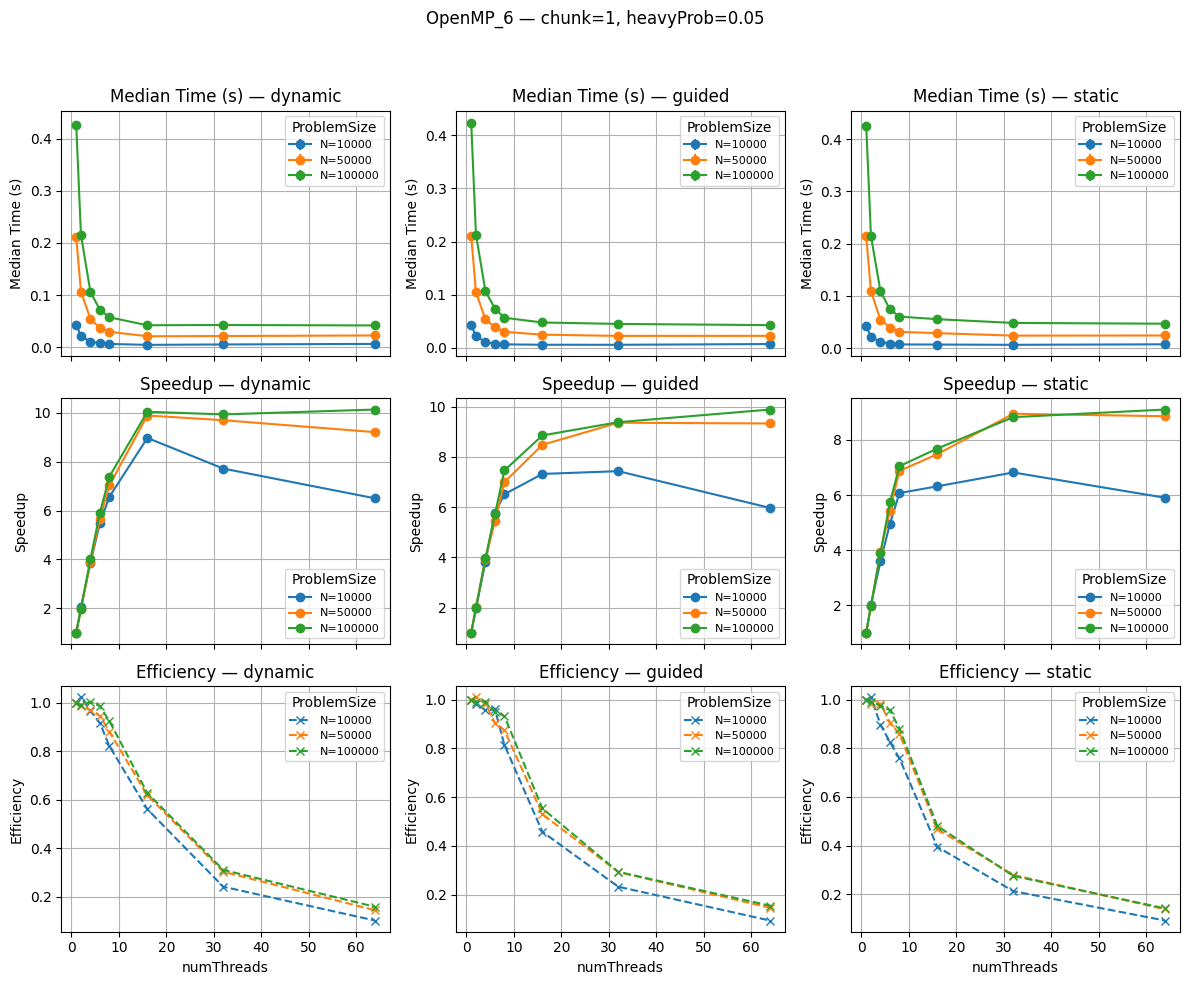

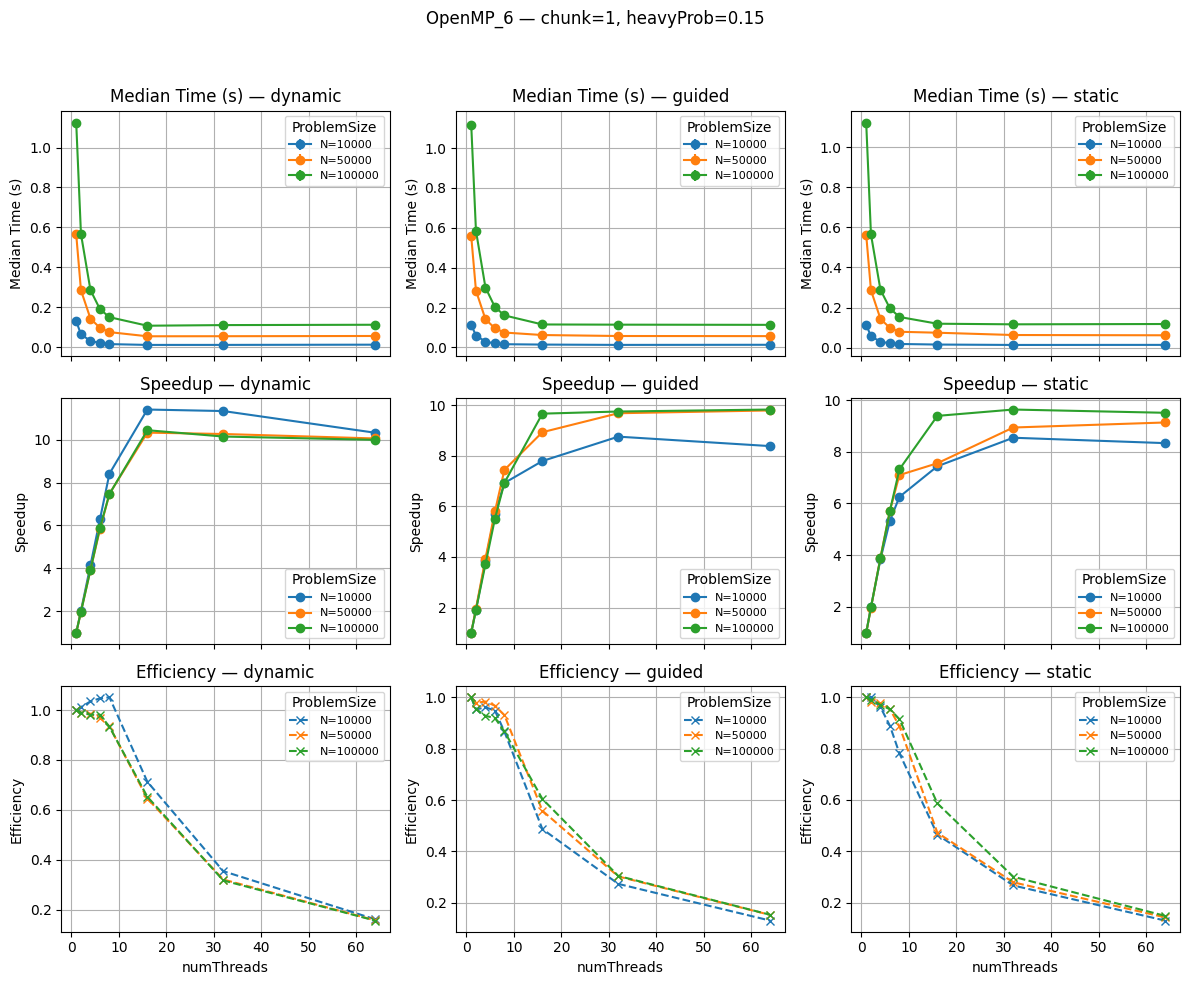

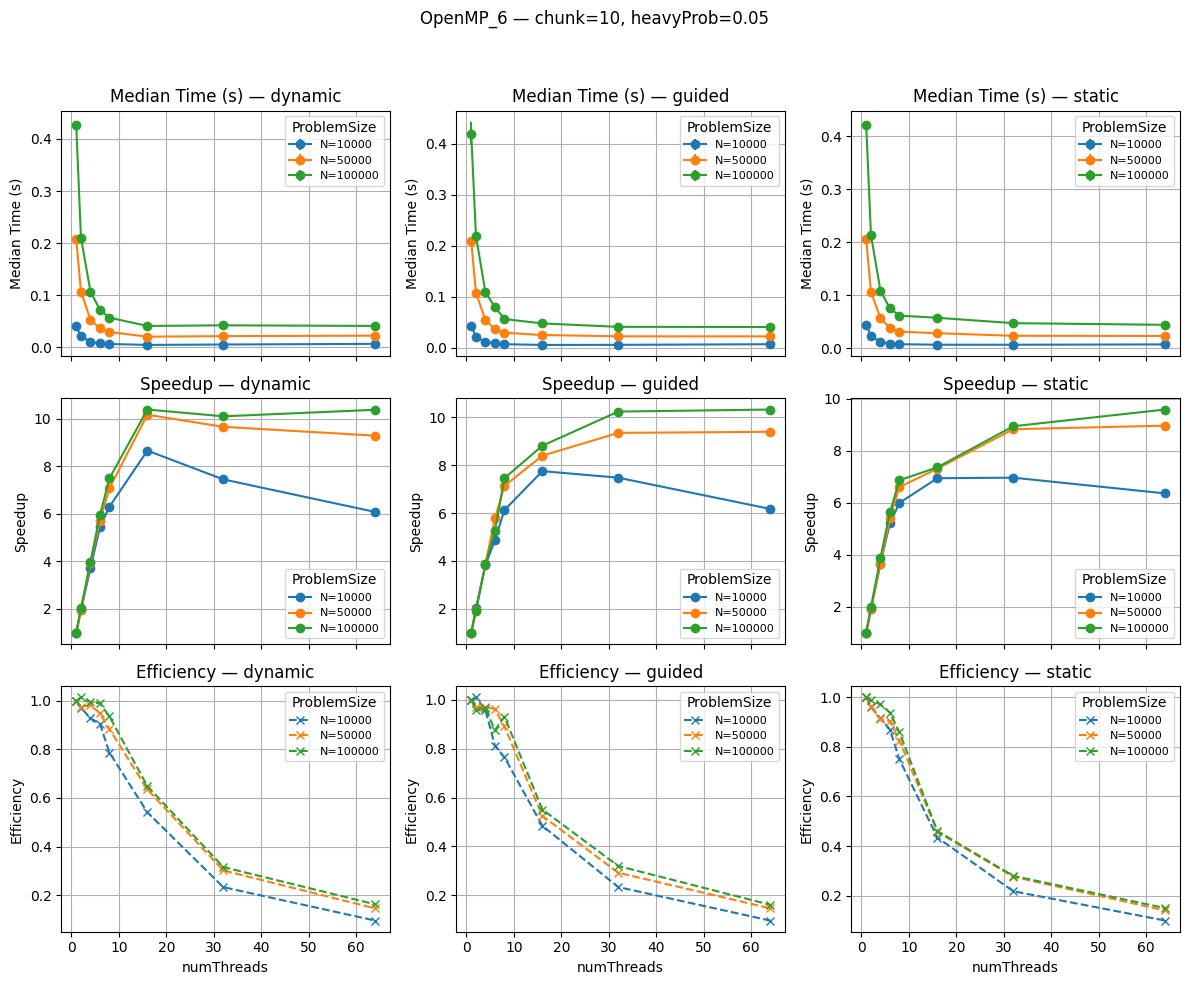

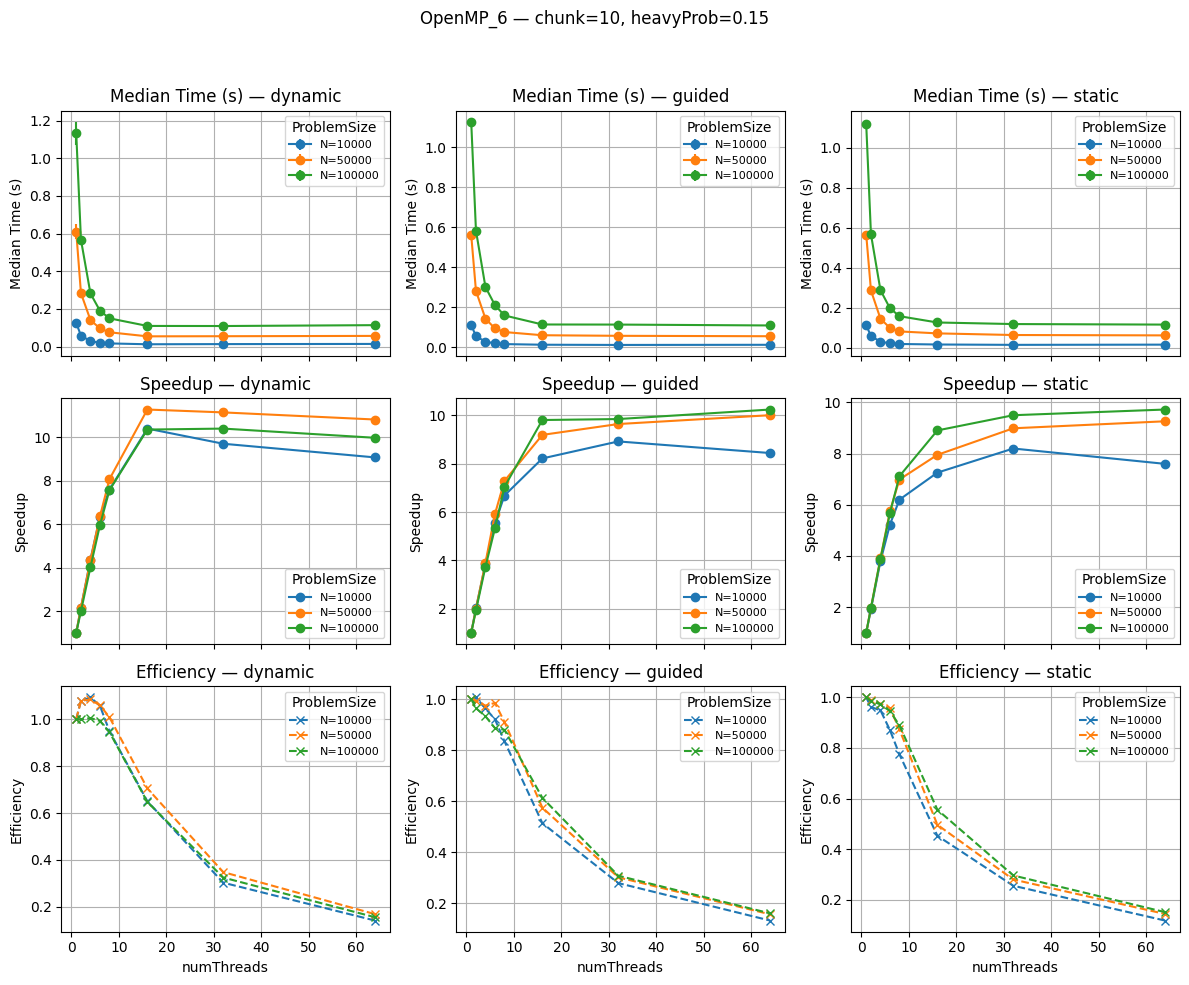

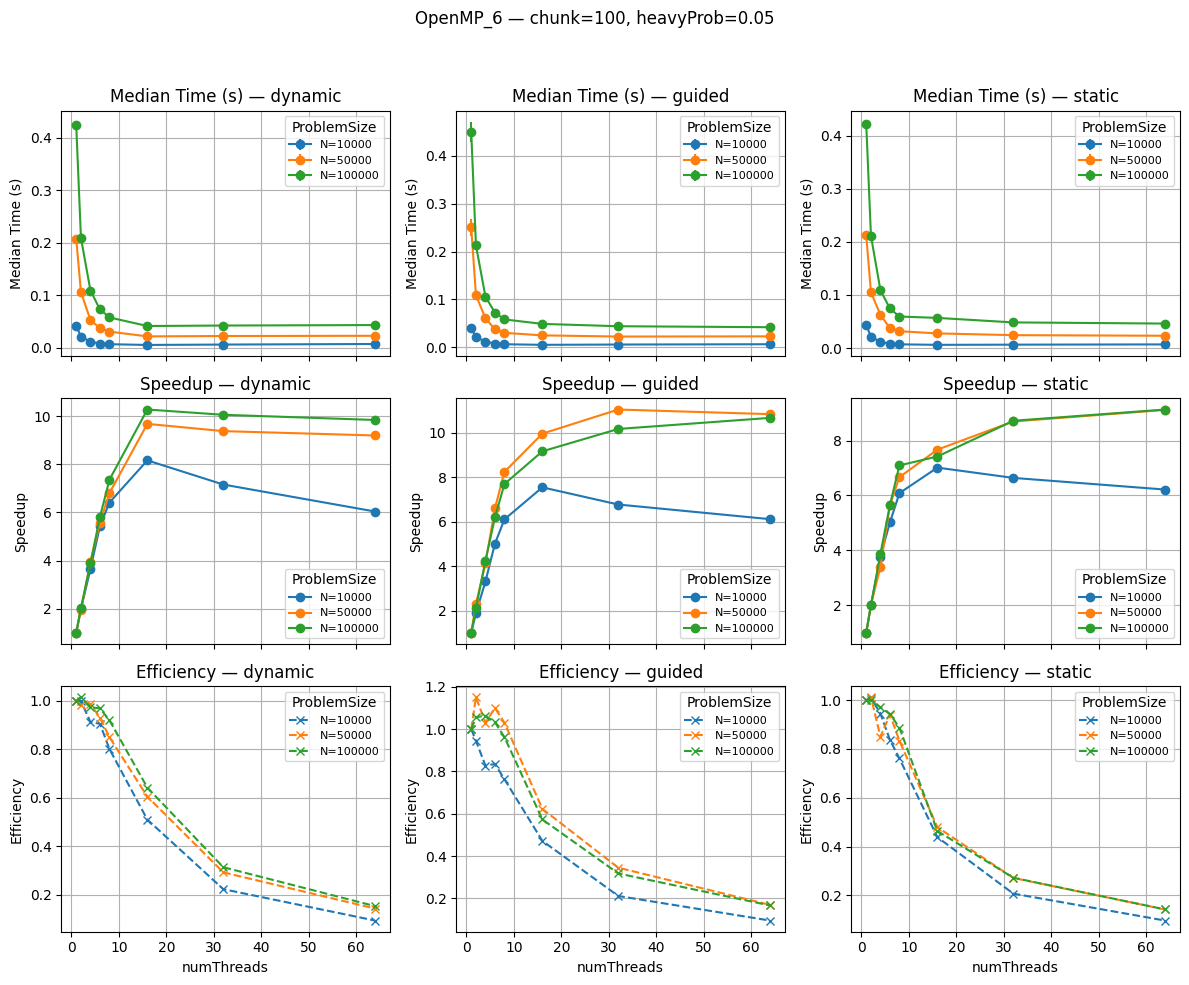

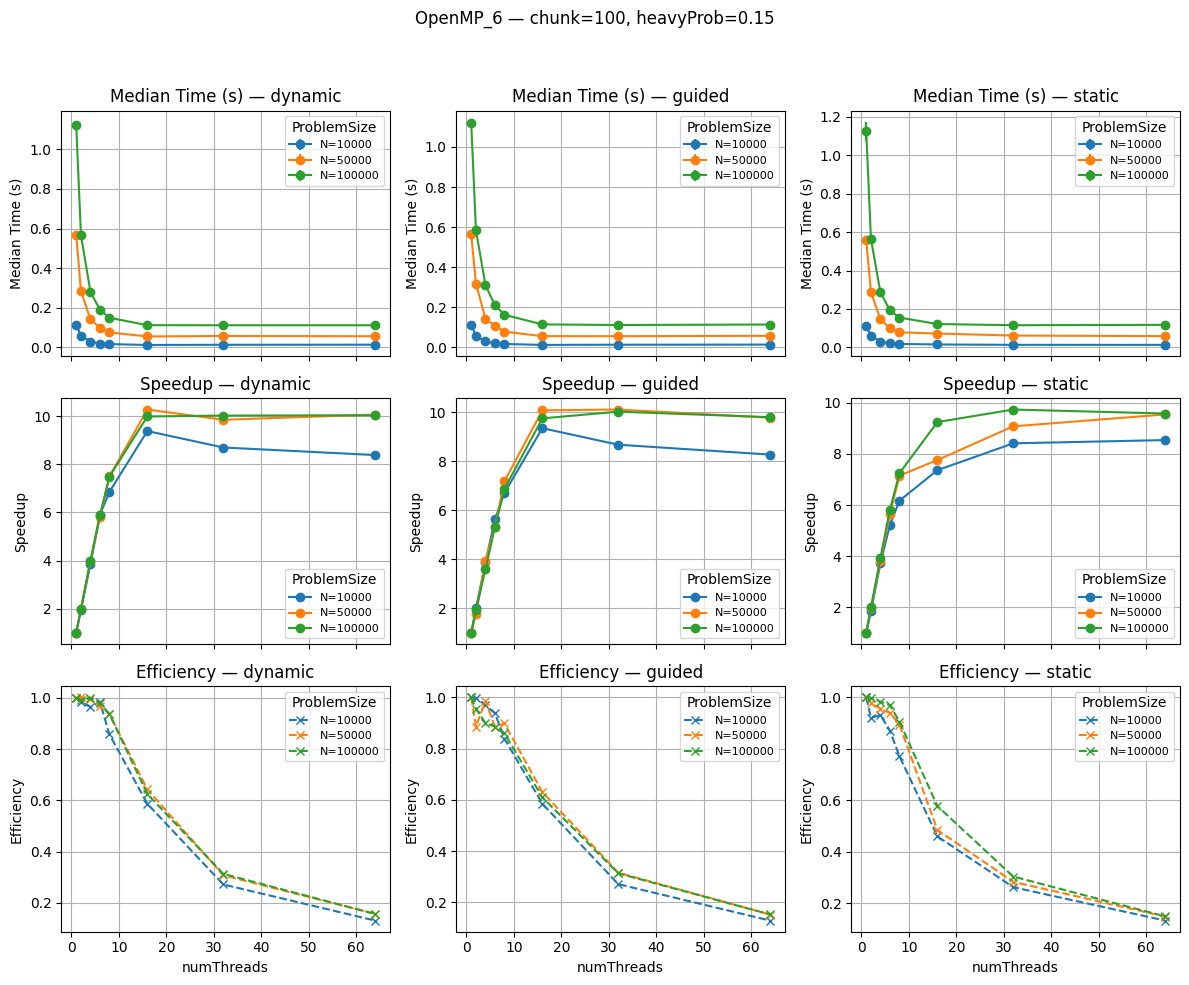

In [ ]:
metrics = ["median", "speedup", "efficiency"]
metricLabels = {
    "median":"Median Time (s)",
    "speedup":"Speedup",
    "efficiency":"Efficiency"
}

problemSizeList = sorted(perfFrame["problemSize"].unique())
heavyProbList = sorted(perfFrame["heavyProbability"].unique())
schedules = sorted(perfFrame["schedule"].unique())
chunkList = sorted(perfFrame["chunk"].unique())

for chunkVal in chunkList:
    for heavyProbVal in heavyProbList:
        filterFrame = perfFrame[(perfFrame["chunk"] == chunkVal) & (perfFrame["heavyProbability"] == heavyProbVal)]
        if filterFrame.empty:
            print(f"No data for chunk={chunkVal}, heavyProb={heavyProbVal}")
            continue

        numCols = max(1, len(schedules))
        fig, axes = plt.subplots(len(metrics), numCols, figsize=(4 * numCols, 10), sharex=True)
        if len(metrics) == 1 and numCols == 1:
            axes2d = np.array([[axes]])
        elif len(metrics) == 1:
            axes2d = np.array([axes])
        elif numCols == 1:
            axes2d = np.array([[ax] for ax in axes])
        else:
            axes2d = axes

        for colIdx, scheduleVal in enumerate(schedules):
            for rowIdx, metric in enumerate(metrics):
                ax = axes2d[rowIdx][colIdx]
                subForSchedule = filterFrame[filterFrame["schedule"] == scheduleVal]
                if subForSchedule.empty:
                    ax.text(0.5, 0.5, 'no data', ha='center', va='center')
                    ax.set_title(f"{scheduleVal}")
                    ax.grid(True)
                    continue

                for problemSizeVal in sorted(subForSchedule["problemSize"].unique()):
                    subFrame = subForSchedule[subForSchedule["problemSize"] == problemSizeVal].sort_values("numThreads")
                    if subFrame.empty:
                        continue
                    
                    x = subFrame["numThreads"].values
                    y = subFrame[metric].values

                    if metric == "median":
                        yerr = subFrame["std"].values
                        ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"N={problemSizeVal}")
                    else:
                        linestyle = '-' if metric == 'speedup' else '--'
                        markerStyle = 'o' if metric == 'speedup' else 'x'
                        ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"N={problemSizeVal}")

                ax.set_title(f"{metricLabels[metric]} — {scheduleVal}")
                if rowIdx == len(metrics) - 1:
                    ax.set_xlabel('numThreads')
                ax.set_ylabel(metricLabels[metric])
                ax.grid(True)
                ax.legend(fontsize=8, title="ProblemSize")

        plt.suptitle(f"OpenMP_6 — chunk={chunkVal}, heavyProb={heavyProbVal}")
        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()


In [8]:
for heavyProbVal in perfFrame["heavyProbability"].unique():
    sample = perfFrame[perfFrame["heavyProbability"] == heavyProbVal]
    print(f"\n=== heavyProbability = {heavyProbVal} — median time (s) ===")
    display(sample.pivot_table(index=["numThreads","schedule","chunk"], columns="problemSize", values="median"))
    print(f"\n=== heavyProbability = {heavyProbVal} — speedup ===")
    display(sample.pivot_table(index=["numThreads","schedule","chunk"], columns="problemSize", values="speedup"))



=== heavyProbability = 0.05 — median time (s) ===


problemSize                  10000     50000     100000
numThreads schedule chunk                              
1          dynamic  1      0.043429  0.210830  0.426203
                    10     0.041023  0.208716  0.427079
                    100    0.042025  0.207587  0.423303
           guided   1      0.042983  0.210889  0.422879
                    10     0.042831  0.209952  0.420245
...                             ...       ...       ...
64         guided   10     0.006934  0.022343  0.040696
                    100    0.006615  0.023088  0.042137
           static   1      0.007268  0.024141  0.046689
                    10     0.006912  0.022855  0.043903
                    100    0.006992  0.023298  0.046224

[72 rows x 3 columns]


=== heavyProbability = 0.05 — speedup ===


problemSize                  10000      50000      100000
numThreads schedule chunk                                
1          dynamic  1      1.000000   1.000000   1.000000
                    10     1.000000   1.000000   1.000000
                    100    1.000000   1.000000   1.000000
           guided   1      1.000000   1.000000   1.000000
                    10     1.000000   1.000000   1.000000
...                             ...        ...        ...
64         guided   10     6.176552   9.396769  10.326445
                    100    6.114760  10.841350  10.673903
           static   1      5.901825   8.860840   9.103571
                    10     6.363557   8.968891   9.589319
                    100    6.216171   9.115707   9.130379

[72 rows x 3 columns]


=== heavyProbability = 0.15 — median time (s) ===


problemSize                  10000     50000     100000
numThreads schedule chunk                              
1          dynamic  1      0.130301  0.564453  1.122860
                    10     0.125275  0.610614  1.132760
                    100    0.114535  0.567287  1.120430
           guided   1      0.113962  0.558180  1.116520
                    10     0.112340  0.560907  1.124830
...                             ...       ...       ...
64         guided   10     0.013304  0.056031  0.109791
                    100    0.013764  0.057617  0.114019
           static   1      0.013638  0.061497  0.117756
                    10     0.014662  0.061022  0.115081
                    100    0.013126  0.058711  0.117402

[72 rows x 3 columns]


=== heavyProbability = 0.15 — speedup ===


problemSize                  10000      50000      100000
numThreads schedule chunk                                
1          dynamic  1      1.000000   1.000000   1.000000
                    10     1.000000   1.000000   1.000000
                    100    1.000000   1.000000   1.000000
           guided   1      1.000000   1.000000   1.000000
                    10     1.000000   1.000000   1.000000
...                             ...        ...        ...
64         guided   10     8.444013  10.010673  10.245193
                    100    8.276834   9.783830   9.804594
           static   1      8.332906   9.131227   9.505843
                    10     7.596778   9.259481   9.718285
                    100    8.542336   9.544261   9.581268

[72 rows x 3 columns]

In [ ]:
summaryRows = []
for (problemSizeVal, heavyProbVal, scheduleVal, chunkVal), sub in perfFrame.groupby(["problemSize","heavyProbability","schedule","chunk"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestThreads = int(argMax["numThreads"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numThreads"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "problemSize": problemSizeVal,
        "heavyProbability": heavyProbVal,
        "schedule": scheduleVal,
        "chunk": chunkVal,
        "bestNumThreads": bestThreads,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Thread": medianAtOne
    })

summaryAnalysisFrame = pd.DataFrame(summaryRows).sort_values(["problemSize","heavyProbability","schedule","chunk"])
display(summaryAnalysisFrame)


,problemSize,heavyProbability,schedule,chunk,bestNumThreads,maxSpeedup,efficiencyAtBest,medianTime1Thread
0,10000,0.05,dynamic,1,16,8.975489,0.560968,0.043429
1,10000,0.05,dynamic,10,16,8.655105,0.540944,0.041023
2,10000,0.05,dynamic,100,16,8.159066,0.509942,0.042025
3,10000,0.05,guided,1,32,7.430352,0.232198,0.042983
4,10000,0.05,guided,10,16,7.753675,0.484605,0.042831
5,10000,0.05,guided,100,16,7.547265,0.471704,0.040447
6,10000,0.05,static,1,32,6.819202,0.213100,0.042892
7,10000,0.05,static,10,32,6.967935,0.217748,0.043983
8,10000,0.05,static,100,16,7.015253,0.438453,0.043462
9,10000,0.15,dynamic,1,16,11.401708,0.712607,0.130301
